#### RMSD Kernel

In [7]:
import numpy as np
from scipy.spatial.transform import Rotation as R
from PQAnalysis.core.api import delta_atomic_positions

def _rmsd(a, b, cell):
    
    rot, _ = R.align_vectors(a, b)
    b = rot.apply(b)
    
    return np.sqrt(np.mean(delta_atomic_positions(a, b, cell=cell)**2))

#### Naive Approach

In [8]:
from PQAnalysis.io import read_trajectory

def rmsd_naive(filename_i, filename_j = None):
    traj_i = read_trajectory(filename_i)
    if filename_j is None or filename_i == filename_j:
        traj_j = traj_i
    else:
        traj_j = read_trajectory(filename_j)
        
    rmsd = np.zeros((len(traj_i), len(traj_j)))
    
    for i, frame_i in enumerate(traj_i):
        for j, frame_j in enumerate(traj_j):
            rmsd[i, j] = _rmsd(frame_i.pos, frame_j.pos, frame_i.cell)
            
    return rmsd.squeeze()

rmsd_scalar = rmsd_naive("start_frame.xyz", "end_frame.xyz")
rmsd_1d = rmsd_naive("start_frame.xyz", "traj.xyz")
rmsd_2d = rmsd_naive("traj.xyz", "traj.xyz")
    

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 101/101 [00:00<00:00, 307.61it/s]


RMSD Start-End 2.78 Å


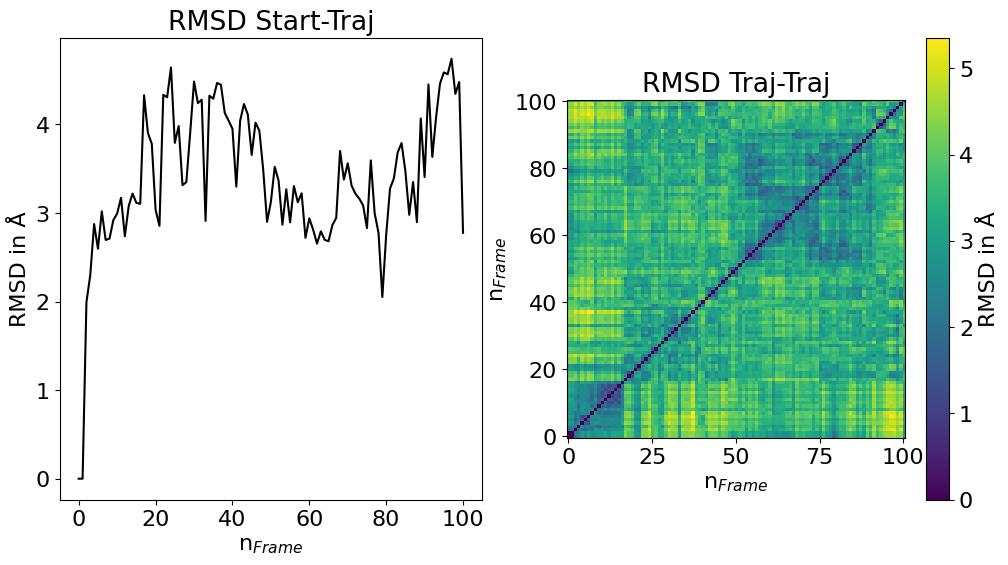

In [9]:
import matplotlib.pyplot as plt

print(f"RMSD Start-End {rmsd_scalar:.2f} Å")

# increase font size of plots
plt.rcParams.update({'font.size': 16})

#plot 1d and 2d RMSD next to each other
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].plot(rmsd_1d, color="black")
ax[0].set_title("RMSD Start-Traj")
ax[0].set_xlabel("n$_{Frame}$")
ax[0].set_ylabel("RMSD in Å")

ax[1].imshow(rmsd_2d, cmap="viridis", origin="lower")
ax[1].set_title("RMSD Traj-Traj")
ax[1].set_xlabel("n$_{Frame}$")
ax[1].set_ylabel("n$_{Frame}$")

# add colorbar
cbar = plt.colorbar(ax[1].imshow(rmsd_2d, cmap="viridis", origin="lower"), ax=ax[1])
# add label to colorbar
cbar.set_label("RMSD in Å")


#### Fancy Naive Approach

In [10]:
from PQAnalysis.io import read_trajectory
import itertools

def rmsd_naive(filename_i, filename_j = None):
    traj_i = read_trajectory(filename_i)
    
    if filename_j is None or filename_i == filename_j:
        traj_j = traj_i
    else:
        traj_j = read_trajectory(filename_j)
        
    rmsd = itertools.starmap(lambda a, b: _rmsd(a.pos, b.pos, a.cell), itertools.product(traj_i, traj_j))
    
    return np.fromiter(rmsd, dtype = np.float64).reshape(len(traj_i), len(traj_j)).squeeze()

rmsd_scalar = rmsd_naive("start_frame.xyz", "end_frame.xyz")
rmsd_1d = rmsd_naive("start_frame.xyz", "traj.xyz")
rmsd_2d = rmsd_naive("traj.xyz", "traj.xyz")

100%|██████████| 101/101 [00:00<00:00, 326.56it/s]


#### Estimated Virtual Memory Usage

In [11]:
from PQAnalysis.io import TrajectoryReader

reader = TrajectoryReader("traj.xyz")

frame_vmem = reader.estimate_vmem_of_frame()
traj_vmem = reader.estimate_vmem_of_traj()

print(f"frame vmem: {frame_vmem:5.2f}MB")
print(f"taj vmem: {traj_vmem:5.2f}MB")

frame vmem:  0.12MB
taj vmem: 11.64MB


In [12]:
n_frames = reader.calculate_total_frame_number()

print(f"total number of frames: {n_frames}")
print(f"Machine with 8GB of RAM can handle {8*1024 / traj_vmem * n_frames:5.2f} frames")
print(f"Machine with 64GB (office desktop) {64*1024 / traj_vmem * n_frames:5.2f} frames")

total number of frames: 101
Machine with 8GB of RAM can handle 71085.19 frames
Machine with 64GB (office desktop) 568681.54 frames


#### Naive Scalable Approach

In [13]:
import itertools

def rmsd(filename_i, filename_j= None):
    filename_j = filename_i if not filename_j or filename_i == filename_j else filename_j
    
    reader_i = TrajectoryReader(filename_i)
    reader_j = TrajectoryReader(filename_j)
    
    traj_i = reader_i.frame_generator()
    traj_j = reader_j.frame_generator()
    
    n_frames_i = reader_i.calculate_total_frame_number()
    n_frames_j = reader_j.calculate_total_frame_number()
    
    rmsd = itertools.starmap(lambda a, b: _rmsd(a.pos, b.pos, a.cell), itertools.product(traj_i, traj_j))
    
    return np.fromiter(rmsd, dtype=float).reshape(n_frames_i, n_frames_j).squeeze()

rmsd_scalar = rmsd("start_frame.xyz", "end_frame.xyz")
rmsd_1d = rmsd("start_frame.xyz", "traj.xyz")
rmsd_2d = rmsd("traj.xyz")

#### Efficient Scalable Approach

In [15]:
from PQAnalysis.io import TrajectoryReader

def rmsd(filename_i, filename_j= None):
    filename_j = filename_i if not filename_j or filename_i == filename_j else filename_j
    symmetry = filename_i == filename_j
    
    reader_i = TrajectoryReader(filename_i)
    reader_j = TrajectoryReader(filename_j)
    
    traj_i = reader_i.chunk_frame_generator(scaling_factor=1 if symmetry else 2)
    traj_j = reader_j.chunk_frame_generator(scaling_factor=1 if symmetry else 2)
    
    n_frames_i = reader_i.calculate_total_frame_number()
    n_frames_j = reader_j.calculate_total_frame_number()
    
    rmsd = np.zeros((n_frames_i, n_frames_j))
    
    for traj_index_i, sub_traj_i in enumerate(traj_i):
        super_index_i = traj_index_i * len(sub_traj_i)
        for frame_index_i, frame_i in enumerate(sub_traj_i):
            index_i = super_index_i + frame_index_i
            for traj_index_j, sub_traj_j in enumerate(traj_j if not symmetry else [sub_traj_i]):
                super_index_j = traj_index_j * len(sub_traj_j)
                for frame_index_j, frame_j in enumerate(sub_traj_j):
                    index_j = super_index_j + frame_index_j
                    
                    if symmetry and index_i >= index_j:
                        continue
                    
                    rmsd[index_i, index_j] = _rmsd(frame_i.pos, frame_j.pos, frame_i.cell)
                    
                    if symmetry:
                        rmsd[index_j, index_i] = rmsd[index_i, index_j]

    return rmsd.squeeze()                        

rmsd_scalar = rmsd("start_frame.xyz", "end_frame.xyz")
rmsd_1d = rmsd("start_frame.xyz", "traj.xyz")
rmsd_2d = rmsd("traj.xyz")